Datasets can be downladed [here](https://www.dropbox.com/s/lpscf6ud58hawzh/Nestorowa-2016-raw.h5ad?dl=0)

Reference: Nestorowa, S. et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood 128, e20-31 (2016).

In [1]:
import stream2 as st
st.__version__

'0.1a'

# 1. Load Data

In [2]:
adata = st.read_h5ad('Nestorowa-2016-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 1656 × 40594
    obs: 'label', 'label_color'

In [3]:
workdir = 'result_stream2'
st.settings.set_workdir(workdir)

Saving results in: result_stream2


In [4]:
st.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[6,5],
                              rc={'image.cmap': 'viridis'})

## 2. Preprocessing

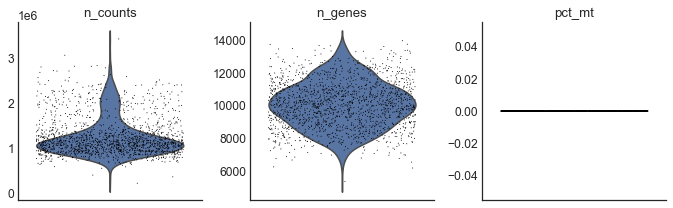

In [5]:
st.pp.cal_qc_rna(adata)
st.pl.violin(adata,list_obs=['n_counts','n_genes','pct_mt'])

In [6]:
st.pp.filter_samples(adata,min_n_features=100)
st.pp.filter_genes(adata,min_n_cells=5)

before filtering: 
1656 samples, 40594 feature
filter samples based on min_n_features
after filtering out low-quality samples: 
1656 samples, 40594 feature
Before filtering: 
1656 cells, 40594 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1656 cells, 35077 genes


In [7]:
# Normalize gene expression based on library size  
st.pp.normalize(adata,method='lib_size')
# Logarithmize gene expression
st.pp.log_transform(adata)

## 3. Feature Selection

You can select features by top variable features, top PCs, or the combination of those two ways.

3000 variable genes are selected.


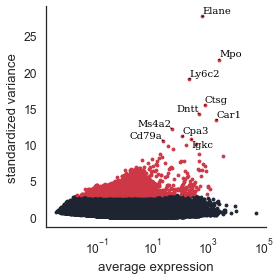

In [9]:
st.pp.select_variable_genes(adata,n_top_genes=3000)
st.pl.variable_genes(adata,show_texts=True)

the number of selected PC is: 50


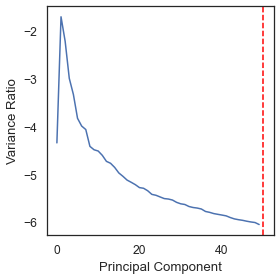

In [10]:
st.pp.pca(adata,feature='highly_variable', n_components=50)
st.pl.pca_variance_ratio(adata, log=True)

## 4. Dimension Reduction

 Currently supported dimension reduction methods are **'umap','se','mlle','tsne', and 'isomap'**. 'umap' is the default setting. Corresponding low dimensional components are stored in **adata.obsm['X_dr']**

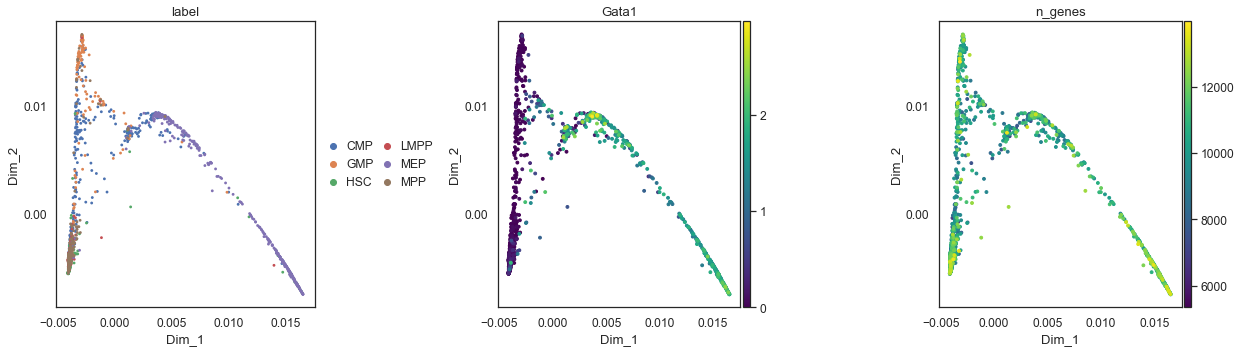

In [11]:
# 'se' - Spectral embedding algorithm
st.tl.dimension_reduction(adata,obsm='X_pca',method='se',n_dim=40, n_neighbors = 15, n_components=2, n_jobs=4)
st.pl.dimension_reduction(adata,color=['label','Gata1','n_genes'],
                          fig_legend_ncol=2, fig_size=(5.5,5))

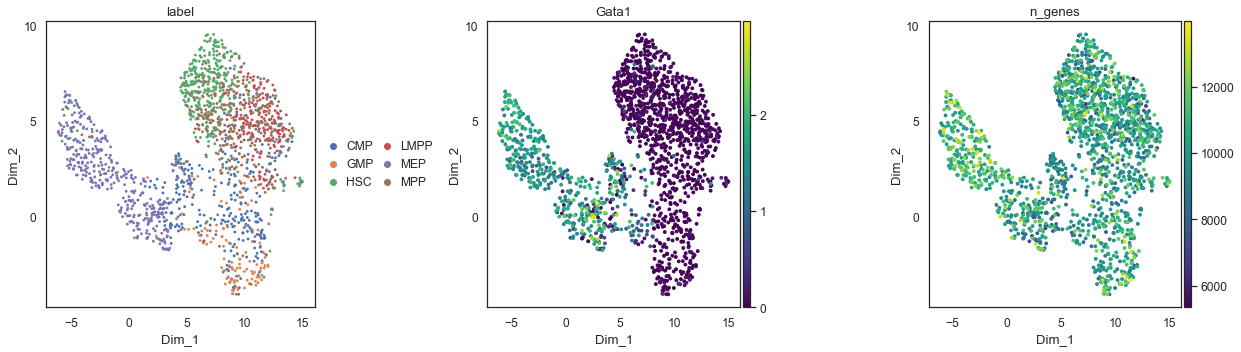

In [12]:
# 'umap' - Uniform Manifold Approximation and Projection
st.tl.dimension_reduction(adata,obsm='X_pca',n_dim=40, n_neighbors = 15, min_dist=0.7, n_components=2, n_jobs=4)
st.pl.dimension_reduction(adata,color=['label','Gata1','n_genes'],
                          fig_legend_ncol=2, fig_size=(5.5,5))

## 5. Trajectory inference

STREAM2 is able to learn not only linear or tree-like structures but also more complex graphs with loops or disconnected components. You can set parameter **'method'** in function **st.tl.learn_graph()** to 'principal_tree' or 'principal_circle' if you have preliminary expections for the structure.

### default

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


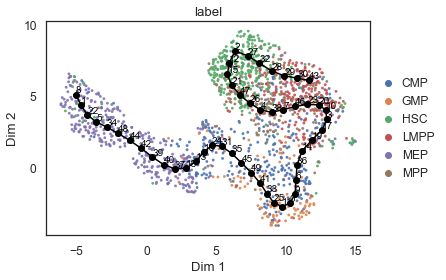

In [13]:
st.tl.seed_graph(adata)
st.tl.learn_graph(adata)
st.pl.graph(adata, color=['label'],show_text=True, show_node=True)

### principal tree

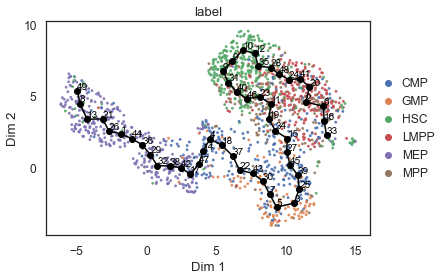

In [14]:
st.tl.learn_graph(adata, method='principal_tree', use_seed=False)
st.pl.graph(adata, color=['label'],show_text=True, show_node=True)

## principal circle

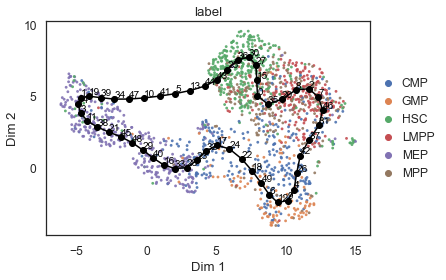

In [15]:
st.tl.learn_graph(adata, method='principal_circle', use_seed=False)
st.pl.graph(adata, color=['label'],show_text=True, show_node=True)

### Dive into the most important parameters for graph learning

**epg_alpha, epg_mu, epg_lambda** are the three most influential parameters for learning elastic principal graph.

> - **epg_alpha**: penalizes spurious branching events. The larger, the fewer branches the function will learn. (by default, epg_alpha=0.02)
> - **epg_mu**: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. The larger, the more edges the function will use to fit into points(cells) (by default, epg_mu=0.1)
> - **epg_lambda**: penalizes the total length of edges. The larger, the 'shorter' curves the function will use to fit into points(cells) and the fewer points(cells) the curves will reach. (by default, epg_lambda=0.01)

Here, we show an example on the effect of increading or decreading parameter **epg_lambda** when we try to learn **principal_tree** 

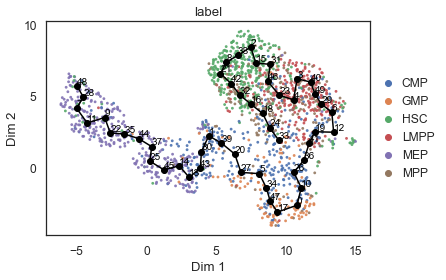

In [16]:
# decrease epg_lambda from 0.01 to 0.005
st.tl.learn_graph(adata, method='principal_tree', use_seed=False,epg_lambda=0.005)
st.pl.graph(adata, color=['label'],show_text=True, show_node=True)

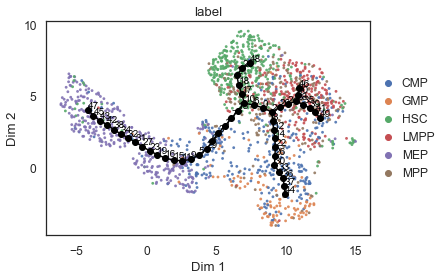

In [17]:
# increase epg_lambda from 0.01 to 0.1
st.tl.learn_graph(adata, method='principal_tree', use_seed=False,epg_lambda=0.1)
st.pl.graph(adata, color=['label'],show_text=True, show_node=True)

## 6. How to edit an existing structure based on supervision?

Sometimes, we have supervision on whether there should have a path or not. Why not directly apply our preliminary knowledge to the structure? Here we use 'principal tree' structure from previous step as an example.

### Add a potential missing branch by providing a set of nodes IDs

/Users/qzhang/miniconda3/envs/stream2_qian/lib/python3.8/site-packages/stream2/tools/_graph_utils.py:279: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  _adata = sc.AnnData(X_fit)


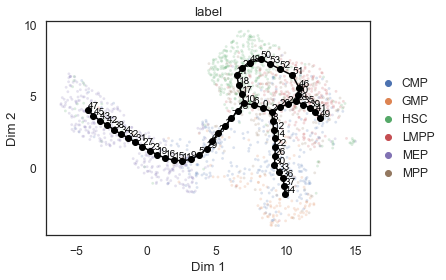

In [19]:
# Here we copy the original data to show how to edit the structure without 
# changing the original structure
adata_add=adata.copy()  
st.tl.add_path(adata_add,48,46)
st.pl.graph(adata_add, color=['label'],show_text=True, show_node=True, alpha=0.2)

### Delete a potential wrong branch by providing a set of nodes IDs

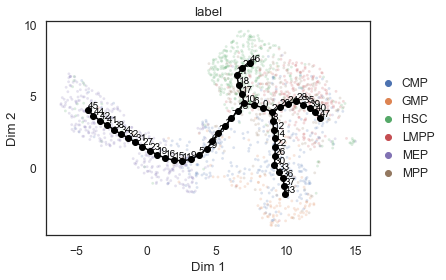

In [20]:
# Here we copy the original data to show how to edit the structure without 
# changing the original structure
adata_del=adata.copy()
st.tl.del_path(adata_del,28,46)
st.pl.graph(adata_del, color=['label'],show_text=True, show_node=True, alpha=0.2)

## 7. Infer pseudotime based on structure

**Pseudotime** is a latent (unobserved) dimension which measures the cells' progress through the transition. 
> - You can infer pseudotime for global structure by specifying start point with parameter **source**. 
> - You can also get local pseudotime for a given path by specifying both start point with parameter **source** and end point with parameter **target** while parameter **nodes_to_include** is optional.

### Based on the global structure

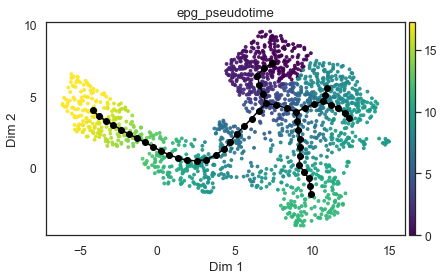

In [21]:
st.tl.infer_pseudotime(adata, source=48)
st.pl.graph(adata, color=['epg_pseudotime'],show_text=False, show_node=True)

### Based on a given path

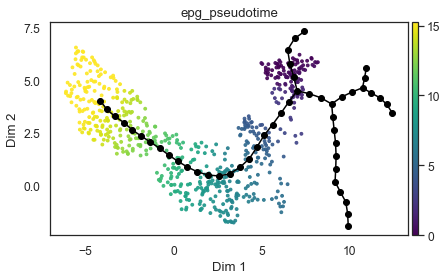

In [22]:
st.tl.infer_pseudotime(adata, source=18, target=47)
st.pl.graph(adata, color=['epg_pseudotime'],show_text=False, show_node=True)

## 8. Transition marker detection based on pseudotime

Let's detect genes that are highly correlated with pseudotime!
> Transition markers are detected based the given path from previous step. So, keep in mind to run infer_pseudotime() before detect_transition_markers().

In [23]:
st.tl.detect_transition_markers(adata)

622  Cells are slected for Path_Source_Nodes-to-include_Target :  Path_18-None-47
Filtering out markers that are expressed in less than 5 cells ...


/Users/qzhang/miniconda3/envs/stream2_qian/lib/python3.8/site-packages/stream2/tools/_markers.py:212: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_pos_scaled = df_pos / maxValues[:, None].T


35062 markers are being scanned ...


> Every time you run st.tl.detect_transition_markers() for a different path. The result table will be automatically stored in **adata.uns['transition_markers']** as a dictionary. And keys for it stand for differnt paths in a format of  **Path_Source_Nodes-to-include_Target**.

In [24]:
df_markers = adata.uns['transition_markers']['Path_18-None-47']
df_markers.head(5)

stat     logfc           pval           qval  initial_mean  \
Blvrb    0.904601  2.716375  5.676810e-232  7.377015e-228      0.138411   
Fxyd5   -0.845645  4.374419  2.556852e-171  1.661314e-167      0.744700   
Tmem14c  0.838331  1.841158  1.308683e-165  5.668778e-162      0.262844   
Tmsb4x  -0.832477  3.488737  3.046283e-161  9.896611e-158      0.692684   
Coro1a  -0.828275  4.192736  3.279103e-158  8.522388e-155      0.728101   

         final_mean  initial_mean_ori  final_mean_ori  
Blvrb      0.965385          0.375683        2.715578  
Fxyd5      0.026387          1.956432        0.069024  
Tmem14c    0.967595          0.668419        2.626671  
Tmsb4x     0.052596          2.275232        0.171849  
Coro1a     0.030362          2.207467        0.091753

All features will be calculated pretty quick. You can filter out the markes based on your needs by playing with those factors in the table. Firstly, Cells in the given branch are ordered by pseudotime. And then, the numbers in the table are calculated.

> - **stat**: the correlation between expressions per feature along pseudotime and pseudotime
> - **logfc**: the log2 fold change between the head and tail group of cells
> - **initial_mean_ori/final_mean_ori**: the raw expression for the head/tail group of cells 
> - **initial_mean/final_mean**: the scaled expression for the head/tail group of cells 

The following block is an example to get markes that keep increacing along the pseudotime with correlation > 0.6, logfc >= 1, pval < 0.01, and the raw expression difference between head and tail > 1.

In [25]:
df_markers_up = df_markers[(df_markers['logfc'] >= 1) & (df_markers['pval']<0.01) 
                               & (df_markers['stat']>0.6) & 
                               (abs(df_markers['initial_mean_ori'] - df_markers['final_mean_ori'])>1) ]
df_markers_up = df_markers_up.sort_values(by=['pval','logfc'], ascending= [True,False])
df_markers_up.head(5)

stat     logfc           pval           qval  initial_mean  \
Blvrb    0.904601  2.716375  5.676810e-232  7.377015e-228      0.138411   
Tmem14c  0.838331  1.841158  1.308683e-165  5.668778e-162      0.262844   
Rhd      0.827891  4.787837  6.141140e-158  1.330069e-154      0.023479   
Fam132a  0.819489  2.674044  3.947246e-152  7.327781e-149      0.143912   
Klf1     0.812731  4.255146  1.126470e-147  1.829810e-144      0.038901   

         final_mean  initial_mean_ori  final_mean_ori  
Blvrb      0.965385          0.375683        2.715578  
Tmem14c    0.967595          0.668419        2.626671  
Rhd        0.914813          0.048450        2.032382  
Fam132a    0.972293          0.402941        2.830055  
Klf1       0.923779          0.089088        2.175781

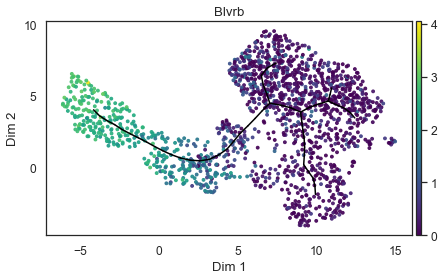

In [26]:
st.pl.graph(adata, color=['Blvrb'],show_text=False, show_node=False)

#### You can easily visualize the scaled expresion per feature along pseudotime for a given branch

In [27]:
st.pl.plot_features_in_pseudotime([adata], ['Gata1','Blvrb'],source=18, target=47)

622  Cells are slected for Path_Source_Nodes-to-include_Target :  Path_18-None-47


The following block is an example to get markes that keep decreasing along the pseudotime with correlation > 0.6, logfc >= 1, pval < 0.01, and the raw expression difference between head and tail > 1.

In [28]:
df_markers_down = df_markers[(df_markers['logfc'] >= 1) & (df_markers['pval']<0.01) 
                               & (df_markers['stat']<-0.6) & 
                               (abs(df_markers['initial_mean_ori'] - df_markers['final_mean_ori'])>1) ]
df_markers_down = df_markers_down.sort_values(by=['pval','logfc'], ascending= [True,False])
df_markers_down.head(5)

stat     logfc           pval           qval  initial_mean  \
Fxyd5  -0.845645  4.374419  2.556852e-171  1.661314e-167      0.744700   
Tmsb4x -0.832477  3.488737  3.046283e-161  9.896611e-158      0.692684   
Coro1a -0.828275  4.192736  3.279103e-158  8.522388e-155      0.728101   
Pkm    -0.806335  4.383155  1.273808e-143  1.379428e-140      0.728182   
Adgrg1 -0.799760  1.933176  1.307765e-139  1.213886e-136      0.799918   

        final_mean  initial_mean_ori  final_mean_ori  
Fxyd5     0.026387          1.956432        0.069024  
Tmsb4x    0.052596          2.275232        0.171849  
Coro1a    0.030362          2.207467        0.091753  
Pkm       0.025376          1.910667        0.066403  
Adgrg1    0.202079          2.640564        0.662945

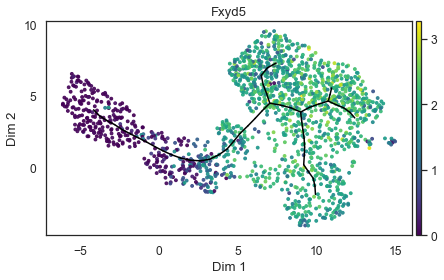

In [29]:
st.pl.graph(adata, color=['Fxyd5'],show_text=False, show_node=False)

In [30]:
st.pl.plot_features_in_pseudotime([adata], ['Fxyd5','Tmsb4x'],source=18, target=47)

622  Cells are slected for Path_Source_Nodes-to-include_Target :  Path_18-None-47
